# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 6

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [23]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [24]:

perm_idx = torch.randperm(X_full.shape[0])
cut = int(0.7 * X_full.shape[0])

train_idx = perm_idx[:cut]
valid_idx = perm_idx[cut:]

X_tr, y_tr = X_full[train_idx], y_full[train_idx]
X_va, y_va = X_full[valid_idx], y_full[valid_idx]

In [25]:
in_features = 2
hidden_units = 16
out_features = 1

lr = 0.1
num_epochs = 5000

def create_param(shape):
    p = torch.randn(shape) * 0.1
    p.requires_grad_()
    return p

W_a = create_param((in_features, hidden_units))
b_a = torch.zeros(hidden_units, requires_grad=True)

W_b = create_param((hidden_units, hidden_units))
b_b = torch.zeros(hidden_units, requires_grad=True)

W_c = create_param((hidden_units, hidden_units))
b_c = torch.zeros(hidden_units, requires_grad=True)

W_d = create_param((hidden_units, out_features))
b_d = torch.zeros(out_features, requires_grad=True)

trainable_params = [W_a, b_a, W_b, b_b, W_c, b_c, W_d, b_d]

In [26]:
def relu_fn(t):
    return torch.maximum(torch.zeros_like(t), t)

def sigmoid_fn(t):
    return 1 / (1 + torch.exp(-t))

def model_forward(X):
    h1 = relu_fn(X @ W_a + b_a)
    h2 = relu_fn(h1 @ W_b + b_b)
    h3 = relu_fn(h2 @ W_c + b_c)
    out = sigmoid_fn(h3 @ W_d + b_d)
    return out

def bce_manual(pred, target):
    pred = torch.clamp(pred, 1e-7, 1 - 1e-7)
    return -(target * torch.log(pred) + (1 - target) * torch.log(1 - pred)).mean()

def accuracy_metric(pred, target):
    cls = (pred >= 0.5).float()
    return (cls == target).float().mean() * 100

In [29]:
loss_train_log, loss_val_log = [], []
acc_train_log, acc_val_log = [], []

for ep in range(num_epochs):


    pred_tr = model_forward(X_tr)
    loss_tr = bce_manual(pred_tr, y_tr)
    loss_tr.backward()

    with torch.no_grad():
        for prm in trainable_params:
            prm -= lr * prm.grad
            prm.grad.zero_()


    with torch.no_grad():
        pred_va = model_forward(X_va)
        loss_va = bce_manual(pred_va, y_va)

        acc_tr = accuracy_metric(pred_tr, y_tr)
        acc_va = accuracy_metric(pred_va, y_va)

    loss_train_log.append(loss_tr.item())
    loss_val_log.append(loss_va.item())
    acc_train_log.append(acc_tr.item())
    acc_val_log.append(acc_va.item())

    if ep % 500 == 0:
        print(f"Epoch {ep}: Loss={loss_tr.item():.4f} | Val Acc={acc_va.item():.3f}%")


Epoch 0: Loss=0.2716 | Val Acc=89.889%
Epoch 500: Loss=0.2701 | Val Acc=89.889%
Epoch 1000: Loss=0.2679 | Val Acc=90.222%
Epoch 1500: Loss=0.2643 | Val Acc=90.778%
Epoch 2000: Loss=0.2601 | Val Acc=91.111%
Epoch 2500: Loss=0.2515 | Val Acc=91.556%
Epoch 3000: Loss=0.2391 | Val Acc=92.111%
Epoch 3500: Loss=0.2269 | Val Acc=92.667%
Epoch 4000: Loss=0.2238 | Val Acc=92.222%
Epoch 4500: Loss=0.2209 | Val Acc=92.222%


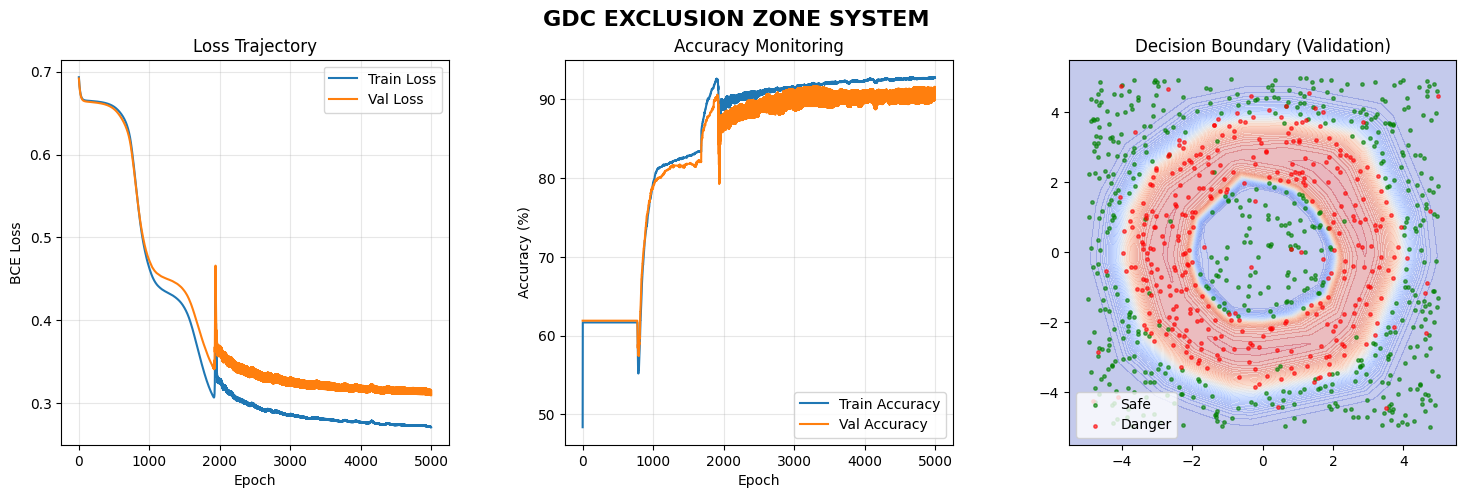

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

axs[0].plot(loss_train_log, label='Train Loss')
axs[0].plot(loss_val_log, label='Val Loss')
axs[0].set_title("Loss Trajectory")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("BCE Loss")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(acc_train_log, label='Train Accuracy')
axs[1].plot(acc_val_log, label='Val Accuracy')
axs[1].set_title("Accuracy Monitoring")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()
axs[1].grid(alpha=0.3)

x_low, x_high = -5.5, 5.5
y_low, y_high = -5.5, 5.5

gx, gy = np.meshgrid(
    np.linspace(x_low, x_high, 300),
    np.linspace(y_low, y_high, 300)
)

grid_pts = torch.tensor(np.c_[gx.ravel(), gy.ravel()], dtype=torch.float32)

with torch.no_grad():
    zz = model_forward(grid_pts).reshape(gx.shape)

axs[2].contourf(gx, gy, zz, levels=50, cmap="coolwarm", alpha=0.3)

safe_mask = (y_va == 0).squeeze()
danger_mask = (y_va == 1).squeeze()

axs[2].scatter(X_va[safe_mask, 0], X_va[safe_mask, 1],
               s=6, c='green', alpha=0.6, label='Safe')

axs[2].scatter(X_va[danger_mask, 0], X_va[danger_mask, 1],
               s=6, c='red', alpha=0.6, label='Danger')

axs[2].set_title("Decision Boundary (Validation)")
axs[2].legend()

plt.suptitle("GDC EXCLUSION ZONE SYSTEM", fontsize=16, weight="bold")
plt.show()
